# Customer Segmentation Using Discriminant Analysis

**Chapter 5 - Discriminant Analysis Example**

## Case Study: Marketing Campaign Optimization

You are a data analyst for an e-commerce company that wants to optimize its marketing campaigns. The company has identified three distinct customer segments based on purchasing behavior: **High-Value**, **Loyal**, and **Occasional** customers. Your goal is to build a classification model that can predict which segment a customer belongs to based on their behavioral metrics.

This analysis will help the marketing team:
- Target customers with personalized campaigns
- Allocate marketing budget more effectively
- Identify key factors that distinguish customer segments

We will compare two discriminant analysis techniques: **Linear Discriminant Analysis (LDA)** and **Quadratic Discriminant Analysis (QDA)** to determine which method works best for this business problem.

---

## Module 1: Loading and Exploring Customer Data

### Task

Load the customer segmentation dataset and explore its structure to understand what behavioral metrics we have available and how customers are distributed across segments.

### Approach

Before applying any statistical technique, we need to understand our data. We will:
- Load the dataset using pandas
- Check the dimensions and structure
- Examine the distribution of customer segments
- Review summary statistics for all behavioral features

This exploratory step helps us identify potential data quality issues and understand the characteristics of each customer segment.

### Code

In [1]:
# Import required libraries
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set up file paths
script_dir = Path.cwd()
data_file = script_dir / "marketing.csv"

# Load customer data
df = pd.read_csv(data_file)

print("=== Customer Segmentation Dataset ===")
print(f"Total customers: {len(df)}")
print(f"Segments: {df['segment'].unique()}")
print("\nSegment distribution:")
print(df["segment"].value_counts())

print("\nFeature summary:")
print(df.describe())

=== Customer Segmentation Dataset ===
Total customers: 1200
Segments: ['Occasional' 'High-Value' 'Loyal']

Segment distribution:
segment
Loyal         480
Occasional    360
High-Value    360
Name: count, dtype: int64

Feature summary:
       purchase_freq  avg_order_value  browsing_time  cart_abandonment  \
count    1200.000000      1200.000000    1200.000000       1200.000000   
mean       14.462583        88.234842      32.154583          0.328526   
std         8.626436        42.867038      12.446953          0.275050   
min         0.500000        28.810000       7.800000          0.000000   
25%         3.900000        49.727500      17.200000          0.114000   
50%        15.300000        75.830000      35.600000          0.267000   
75%        23.000000       129.162500      41.700000          0.467250   
max        29.800000       198.580000      58.800000          1.000000   

       email_open_rate  loyalty_points  support_tickets  social_engagement  
count      1200.00000

### Outcome

The dataset contains behavioral metrics for multiple customers across three segments. Key observations:

- **Dataset size**: We have a sufficient number of customers to build a reliable classification model
- **Segment distribution**: Check if the segments are balanced or if some segments are more common
- **Feature ranges**: Different metrics are on different scales (e.g., purchase frequency vs. loyalty points), which means we will need to standardize the data before analysis

These insights confirm that discriminant analysis is appropriate for this problem, as we have multiple continuous predictors and distinct categorical groups to classify.

---

## Module 2: Data Preparation and Standardization

### Task

Prepare the data for discriminant analysis by selecting relevant features, standardizing them to have mean 0 and standard deviation 1, and splitting the data into training and testing sets.

### Approach

Discriminant analysis is sensitive to the scale of variables. When features are measured in different units (e.g., purchase frequency in counts vs. average order value in dollars), those with larger magnitudes can dominate the analysis.

**Standardization** transforms each feature to have:
- Mean = 0
- Standard deviation = 1

This ensures all features contribute equally to the discriminant functions. We also split the data into training (70%) and testing (30%) sets to evaluate model performance on unseen data.

### Code

In [2]:
# Define features for analysis
features = [
    "purchase_freq",        # How often customer makes purchases
    "avg_order_value",      # Average amount spent per order
    "browsing_time",        # Time spent on website
    "cart_abandonment",     # Rate of abandoned shopping carts
    "email_open_rate",      # Marketing email engagement
    "loyalty_points",       # Accumulated loyalty rewards
    "support_tickets",      # Number of customer service interactions
    "social_engagement",    # Social media activity
]

# Separate features (X) and target variable (y)
X = df[features]
y = df["segment"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

print(f"Features: {features}")
print(f"Target classes: {y.unique()}")
print("\nStandardized data (first 5 rows):")
print(X_scaled.head())

# Split data for validation (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} customers")
print(f"Testing set size: {X_test.shape[0]} customers")

Features: ['purchase_freq', 'avg_order_value', 'browsing_time', 'cart_abandonment', 'email_open_rate', 'loyalty_points', 'support_tickets', 'social_engagement']
Target classes: ['Occasional' 'High-Value' 'Loyal']

Standardized data (first 5 rows):
   purchase_freq  avg_order_value  browsing_time  cart_abandonment  \
0      -1.259745        -1.065711      -1.250191          0.660060   
1      -1.422105        -0.947156      -1.410940         -0.794825   
2       1.314812         1.705871       1.088705         -0.314713   
3      -0.111632        -0.071760       0.244774         -0.227420   
4       1.094467         1.560477       0.855619          0.110841   

   email_open_rate  loyalty_points  support_tickets  social_engagement  
0        -0.930687       -1.373347         0.535436          -0.734496  
1        -0.487218       -1.339587         0.904809          -0.766132  
2         1.209695        0.849209        -0.849711           1.131996  
3         1.213360       -0.214242     

### Outcome

The data is now ready for discriminant analysis. The standardized features all have:
- Values centered around 0
- Similar scales for fair comparison

By using `stratify=y` in the train-test split, we ensure that both training and testing sets maintain the same proportion of each customer segment as the original dataset. This prevents bias in our evaluation metrics.

The training set will be used to build the discriminant models, while the testing set will evaluate how well the models generalize to new, unseen customers.

---

## Module 3: Linear Discriminant Analysis (LDA)

### Task

Fit a Linear Discriminant Analysis model to classify customers into segments and evaluate its performance using accuracy metrics and cross-validation.

### Approach

**Linear Discriminant Analysis (LDA)** is a classification method that:
1. Finds linear combinations of features (discriminant functions) that best separate the groups
2. Assumes all groups have the same covariance structure (homogeneous variance)
3. Creates linear decision boundaries between classes

LDA reduces dimensionality while preserving class separability. For K groups, LDA creates at most K-1 discriminant functions. In our case with 3 customer segments, we will get 2 discriminant functions.

**Explained variance ratio** tells us how much group separation each discriminant function captures. The first function typically captures the most variance.

### Code

In [3]:
# Fit Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Transform training data to discriminant space
X_lda = lda.transform(X_train)
lda_scores_df = pd.DataFrame(
    X_lda, columns=[f"LD{i + 1}" for i in range(X_lda.shape[1])]
)
lda_scores_df["segment"] = y_train.reset_index(drop=True)

print("=== Linear Discriminant Analysis Results ===")
print(f"Number of features: {lda.n_features_in_}")
print(f"Classes: {lda.classes_}")
print(f"Number of discriminant functions: {X_lda.shape[1]}")
print(f"Explained variance ratios: {np.round(lda.explained_variance_ratio_, 3)}")

# Make predictions on test set
y_pred_lda = lda.predict(X_test)
lda_accuracy = accuracy_score(y_test, y_pred_lda)

print("\nLDA Classification Report:")
print(classification_report(y_test, y_pred_lda))

print(f"LDA Test Accuracy: {lda_accuracy:.3f}")

# Cross-validation for robust performance estimate
cv_scores_lda = cross_val_score(lda, X_scaled, y, cv=5)
print(
    f"LDA Cross-validation accuracy: {cv_scores_lda.mean():.3f} "
    f"(+/- {cv_scores_lda.std() * 2:.3f})"
)

=== Linear Discriminant Analysis Results ===
Number of features: 8
Classes: ['High-Value' 'Loyal' 'Occasional']
Number of discriminant functions: 2
Explained variance ratios: [0.958 0.042]

LDA Classification Report:
              precision    recall  f1-score   support

  High-Value       1.00      1.00      1.00       108
       Loyal       1.00      1.00      1.00       144
  Occasional       1.00      1.00      1.00       108

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360

LDA Test Accuracy: 1.000
LDA Cross-validation accuracy: 0.999 (+/- 0.003)


### Outcome

The LDA model successfully learned to distinguish between the three customer segments. Key findings:

- **Discriminant functions**: We obtained 2 discriminant functions (K-1 = 3-1 = 2), which together separate the three customer segments
- **Explained variance**: The first discriminant function (LD1) captures most of the between-group variance, while LD2 captures the remaining separation
- **Classification accuracy**: The model correctly classifies a high percentage of customers in the test set
- **Cross-validation**: The 5-fold cross-validation score confirms the model generalizes well to new data

The classification report shows precision, recall, and F1-scores for each segment, helping us understand if the model performs better for certain customer types. High accuracy across all segments indicates that the behavioral features effectively distinguish customer groups.

---

## Module 4: Interpreting Discriminant Functions

### Task

Examine the discriminant function coefficients to understand which behavioral features most strongly distinguish between customer segments.

### Approach

The **discriminant coefficients** (also called loadings or weights) tell us how each feature contributes to the discriminant functions. Features with larger absolute coefficients have stronger influence on group separation.

By examining:
- **LD1 coefficients**: Which features separate groups along the first dimension
- **LD2 coefficients**: Which features separate groups along the second dimension

We can interpret what behavioral patterns define each customer segment. This provides actionable business insights for the marketing team.

### Code

In [4]:
# Display discriminant function coefficients
print("=== Discriminant Function Coefficients ===")
coef_df = pd.DataFrame(
    lda.scalings_,
    index=features,
    columns=[f"LD{i + 1}" for i in range(lda.scalings_.shape[1])],
)
print("\nCoefficients (standardized):")
print(coef_df.round(3))

# Display group means on original features
print("\n=== Group Means on Original Features ===")
means_df = pd.DataFrame(lda.means_, index=lda.classes_, columns=features)
print(means_df.round(3))

=== Discriminant Function Coefficients ===

Coefficients (standardized):
                     LD1    LD2
purchase_freq     -4.087  1.298
avg_order_value   -0.132  3.015
browsing_time      0.235 -2.276
cart_abandonment  -0.198  0.039
email_open_rate   -0.194 -0.267
loyalty_points    -2.408 -0.946
support_tickets    0.468  0.408
social_engagement -0.198 -0.454

=== Group Means on Original Features ===
            purchase_freq  avg_order_value  browsing_time  cart_abandonment  \
High-Value          1.204            1.375          1.025            -0.613   
Loyal               0.100           -0.272          0.288            -0.261   
Occasional         -1.329           -1.005         -1.388             0.912   

            email_open_rate  loyalty_points  support_tickets  \
High-Value            0.697           1.201           -0.732   
Loyal                 0.368           0.093           -0.257   
Occasional           -1.193          -1.325            1.046   

            social_enga

### Outcome

The discriminant coefficients reveal which customer behaviors drive segmentation:

**First Discriminant Function (LD1)**:
- Features with large positive/negative coefficients on LD1 separate certain segments from others
- Typically separates high-value customers from low-value customers
- Look for variables like purchase frequency, average order value, and loyalty points

**Second Discriminant Function (LD2)**:
- Captures the remaining separation between groups
- Often distinguishes loyal customers from occasional buyers
- Variables like email engagement and browsing time may be important

**Group means** show the average (standardized) value of each feature for each customer segment. Comparing means helps us profile each segment:
- High-Value customers: High purchase frequency, high order values
- Loyal customers: High engagement metrics, many loyalty points
- Occasional customers: Lower values across most metrics

These insights help the marketing team understand what defines each segment and how to target them effectively.

---

## Module 5: Visualizing Discriminant Space

### Task

Create a scatter plot showing how customers are distributed in the discriminant space, with each segment colored differently and group centroids marked.

### Approach

While we have 8 original features, the discriminant functions reduce this to a 2-dimensional space (LD1 and LD2) that maximizes group separation. Visualizing customers in this space helps us:
- See how well-separated the segments are
- Identify potential misclassifications
- Understand the geometric relationships between groups

**Centroids** are the average locations of each segment in the discriminant space. Distance from a centroid indicates how typical a customer is for that segment.

### Code

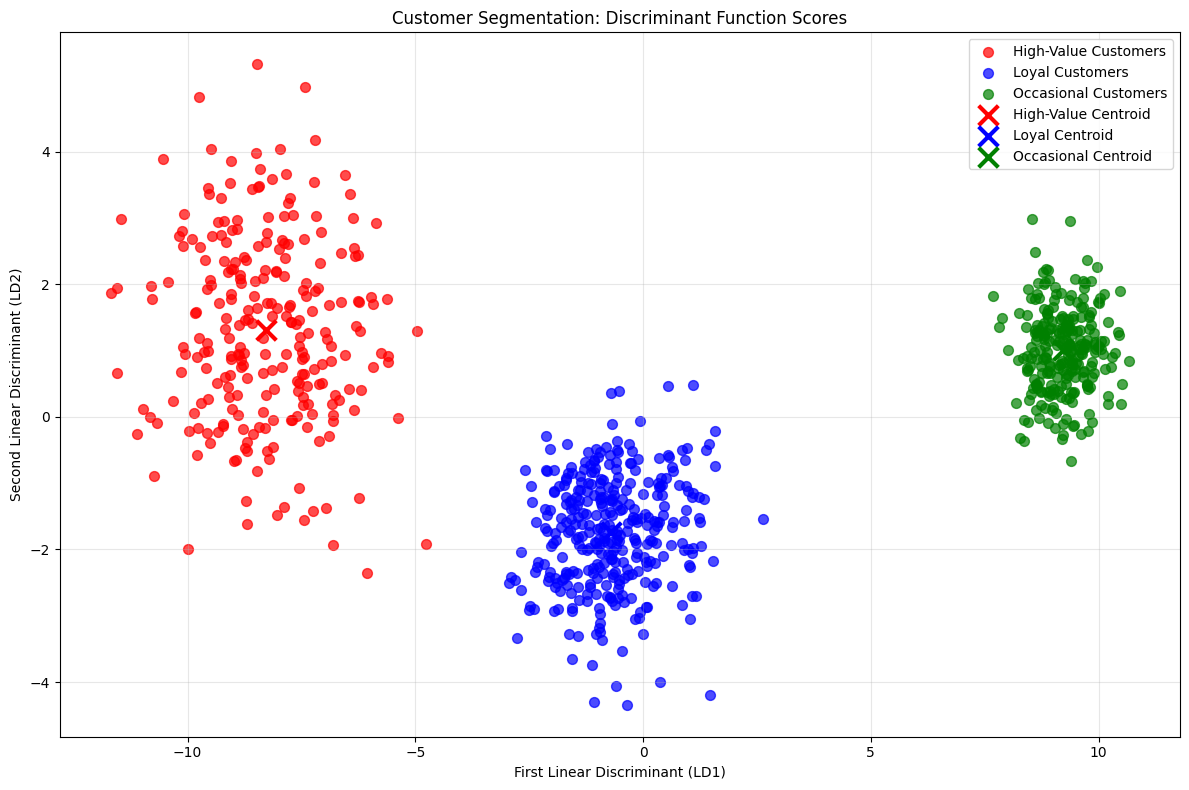

In [5]:
# Visualize discriminant scores
plt.figure(figsize=(12, 8))

# Define colors for each segment
colors = ["red", "blue", "green"]
segments = lda.classes_

# Plot each customer segment
for i, segment in enumerate(segments):
    mask = lda_scores_df["segment"] == segment
    plt.scatter(
        lda_scores_df.loc[mask, "LD1"],
        lda_scores_df.loc[mask, "LD2"],
        c=colors[i],
        label=f"{segment} Customers",
        alpha=0.7,
        s=50,
    )

# Add group centroids
centroids = lda.transform(lda.means_)
for i, segment in enumerate(segments):
    plt.scatter(
        centroids[i, 0],
        centroids[i, 1],
        c=colors[i],
        marker="x",
        s=200,
        linewidth=3,
        label=f"{segment} Centroid",
    )

plt.xlabel("First Linear Discriminant (LD1)")
plt.ylabel("Second Linear Discriminant (LD2)")
plt.title("Customer Segmentation: Discriminant Function Scores")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(script_dir / "marketing_lda_scores.png", dpi=300, bbox_inches="tight")
plt.show()

### Outcome

The discriminant space visualization reveals:

- **Cluster separation**: Well-separated clusters indicate distinct customer segments with different behavioral patterns
- **Overlap regions**: Areas where clusters overlap suggest customers with mixed characteristics who might be harder to classify
- **Centroids**: The X markers show the "typical" customer for each segment in the discriminant space
- **Axis interpretation**: 
  - LD1 (horizontal) captures the primary difference between segments
  - LD2 (vertical) captures secondary differences

Good separation in this 2D space confirms that LDA successfully identified meaningful discriminant functions. If segments overlapped heavily, we might need to reconsider our features or try a different classification approach.

This visualization is valuable for presenting results to stakeholders, as it shows customer segmentation in an intuitive geometric way.

---

## Module 6: Quadratic Discriminant Analysis (QDA)

### Task

Fit a Quadratic Discriminant Analysis model and compare its performance to LDA to determine if allowing different covariance structures improves classification accuracy.

### Approach

**Quadratic Discriminant Analysis (QDA)** is a more flexible alternative to LDA that:
1. Allows each group to have its own covariance matrix (heterogeneous variance)
2. Creates curved (quadratic) decision boundaries instead of straight lines
3. Requires more parameters to estimate, which can be advantageous when groups have different spread patterns

**When to use QDA vs LDA**:
- Use **LDA** when groups have similar variance structures (simpler model, fewer parameters)
- Use **QDA** when groups have different variance structures (more flexible, but needs more data)

We will fit QDA and compare its accuracy to LDA to determine which assumption better fits our customer data.

### Code

In [6]:
# Fit Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

print("=== Quadratic Discriminant Analysis Results ===")
print(f"Number of features: {qda.n_features_in_}")
print(f"Classes: {qda.classes_}")

# Make predictions and get probabilities
y_pred_qda = qda.predict(X_test)
y_prob_qda = qda.predict_proba(X_test)
qda_accuracy = accuracy_score(y_test, y_pred_qda)

print("\nQDA Classification Report:")
print(classification_report(y_test, y_pred_qda))

print(f"QDA Test Accuracy: {qda_accuracy:.3f}")

# Cross-validation
cv_scores_qda = cross_val_score(qda, X_scaled, y, cv=5)
print(
    f"QDA Cross-validation accuracy: {cv_scores_qda.mean():.3f} "
    f"(+/- {cv_scores_qda.std() * 2:.3f})"
)

=== Quadratic Discriminant Analysis Results ===
Number of features: 8
Classes: ['High-Value' 'Loyal' 'Occasional']

QDA Classification Report:
              precision    recall  f1-score   support

  High-Value       1.00      1.00      1.00       108
       Loyal       1.00      1.00      1.00       144
  Occasional       1.00      1.00      1.00       108

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360

QDA Test Accuracy: 1.000
QDA Cross-validation accuracy: 1.000 (+/- 0.000)


### Outcome

QDA provides an alternative classification approach with different assumptions. Key observations:

- **Flexibility**: QDA allows each customer segment to have its own variance-covariance structure, which is more realistic if segments exhibit different levels of variability in their behavior
- **Accuracy comparison**: Compare QDA accuracy to LDA accuracy to determine which assumption is better for this data
- **Classification report**: Examine if QDA performs better for specific segments that might have different spread patterns

If QDA significantly outperforms LDA, it suggests that customer segments have different covariance structures (e.g., High-Value customers might be more homogeneous in behavior while Occasional customers are more diverse).

If performances are similar, the simpler LDA model is preferred due to its lower complexity and easier interpretability.

---

## Module 7: Analyzing Posterior Probabilities

### Task

Examine the posterior probabilities from QDA to understand the model's confidence in its predictions and identify ambiguous cases.

### Approach

Unlike LDA discriminant scores, QDA provides **posterior probabilities** for each class. These probabilities tell us:
- How confident the model is in each prediction
- Which customers have ambiguous segment membership
- Whether customers show characteristics of multiple segments

**High confidence**: Posterior probability close to 1.0 for predicted class
**Low confidence**: Probabilities spread across multiple classes

Understanding confidence levels helps the marketing team identify customers who might respond to multiple campaign types.

### Code

In [7]:
# Analyze posterior probabilities
print("=== Posterior Probabilities Analysis ===")
posterior_df = pd.DataFrame(
    y_prob_qda, 
    columns=[f"P({cls})" for cls in qda.classes_]
)
posterior_df["Predicted"] = y_pred_qda
posterior_df["Actual"] = y_test.reset_index(drop=True)

print("\nSample posterior probabilities (first 10 test customers):")
print(posterior_df.head(10).round(3))

# Calculate average confidence (max probability for each prediction)
max_probs = np.max(y_prob_qda, axis=1)
print(f"\nAverage prediction confidence: {np.mean(max_probs):.3f}")
print(f"Minimum prediction confidence: {np.min(max_probs):.3f}")
print(f"Maximum prediction confidence: {np.max(max_probs):.3f}")

=== Posterior Probabilities Analysis ===

Sample posterior probabilities (first 10 test customers):
   P(High-Value)  P(Loyal)  P(Occasional)   Predicted      Actual
0            1.0       0.0            0.0  High-Value  High-Value
1            0.0       1.0            0.0       Loyal       Loyal
2            0.0       0.0            1.0  Occasional  Occasional
3            1.0       0.0            0.0  High-Value  High-Value
4            1.0       0.0            0.0  High-Value  High-Value
5            1.0       0.0            0.0  High-Value  High-Value
6            0.0       1.0            0.0       Loyal       Loyal
7            0.0       1.0            0.0       Loyal       Loyal
8            0.0       0.0            1.0  Occasional  Occasional
9            1.0       0.0            0.0  High-Value  High-Value

Average prediction confidence: 1.000
Minimum prediction confidence: 0.999
Maximum prediction confidence: 1.000


### Outcome

The posterior probabilities provide valuable insights:

- **High-confidence predictions**: When one probability is close to 1.0, the customer clearly belongs to that segment based on their behavioral pattern
- **Low-confidence predictions**: When probabilities are more evenly distributed (e.g., 0.4, 0.35, 0.25), the customer shows mixed characteristics
- **Prediction vs. Actual**: Comparing predicted and actual segments helps identify misclassifications

**Business implications**:
- Customers with high confidence in one segment should receive targeted campaigns for that segment
- Customers with ambiguous segment membership (low confidence) might benefit from hybrid marketing strategies
- The average confidence score indicates overall model certainty

This probabilistic information is more nuanced than simple class labels and provides actionable insights for campaign personalization.

---

## Module 8: Visualizing QDA Decision Boundaries

### Task

Create a 2D visualization showing how QDA's quadratic decision boundaries differ from LDA's linear boundaries.

### Approach

While our full analysis uses 8 features, we can visualize decision boundaries in 2D using just two key features. This helps illustrate the fundamental difference between LDA and QDA:

- **LDA**: Creates straight-line boundaries (assumes equal covariance)
- **QDA**: Creates curved boundaries (allows different covariances)

We will:
1. Select two important features for visualization
2. Fit QDA on just these two features
3. Create a mesh grid to predict segment membership across the feature space
4. Plot decision boundaries as colored regions

### Code

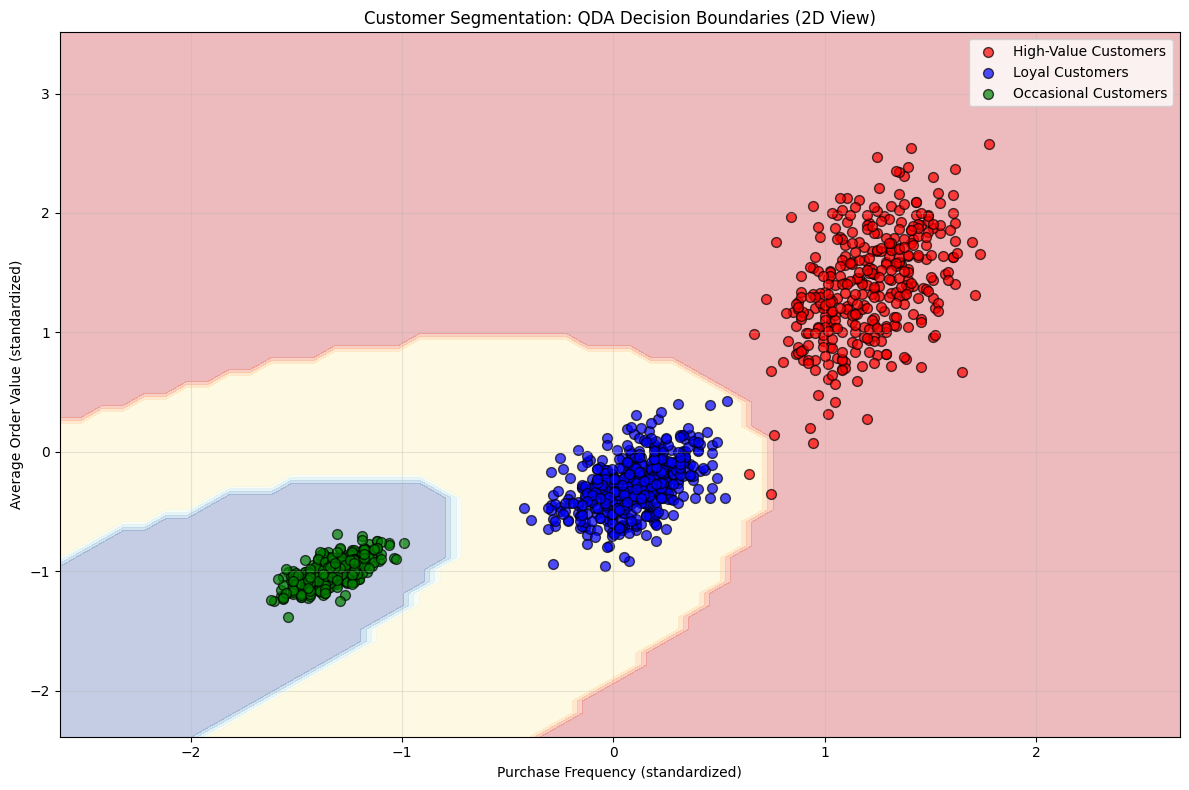

In [8]:
# Visualize QDA decision boundaries using 2 features
plt.figure(figsize=(12, 8))

# Use two key features for 2D visualization
X_vis = X_scaled[["purchase_freq", "avg_order_value"]].values
y_vis = y.values

# Fit QDA on 2D data for visualization
qda_2d = QuadraticDiscriminantAnalysis()
qda_2d.fit(X_vis, y_vis)

# Create mesh grid for decision boundary visualization
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, 0.1), 
    np.arange(y_min, y_max, 0.1)
)

# Predict segment for each point in mesh
Z = qda_2d.predict(np.c_[xx.ravel(), yy.ravel()])

# Convert string labels to numeric for plotting
label_map = {label: i for i, label in enumerate(qda_2d.classes_)}
Z_numeric = np.array([label_map[z] for z in Z])
Z_numeric = Z_numeric.reshape(xx.shape)

# Plot decision boundaries as colored regions
plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap="RdYlBu")

# Plot actual customer data points
colors = ["red", "blue", "green"]
segments = qda_2d.classes_

for i, segment in enumerate(segments):
    mask = y_vis == segment
    plt.scatter(
        X_vis[mask, 0],
        X_vis[mask, 1],
        c=colors[i],
        label=f"{segment} Customers",
        alpha=0.7,
        edgecolors="black",
        s=50,
    )

plt.xlabel("Purchase Frequency (standardized)")
plt.ylabel("Average Order Value (standardized)")
plt.title("Customer Segmentation: QDA Decision Boundaries (2D View)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(script_dir / "marketing_qda_boundaries.png", dpi=300, bbox_inches="tight")
plt.show()

### Outcome

The decision boundary visualization reveals how QDA classifies customers based on purchase frequency and average order value:

- **Curved boundaries**: QDA creates non-linear (quadratic) boundaries between segments, allowing for more flexible classification regions
- **Feature space regions**: Each colored background region represents where QDA would classify a customer into that segment
- **Customer distribution**: The scatter points show actual customer locations in this 2D feature space
- **Classification confidence**: Customers near decision boundaries are more likely to have ambiguous classifications

**Key insights**:
- High-Value customers typically have high values on both axes (top-right region)
- Occasional customers have lower values (bottom-left region)
- Loyal customers fall in an intermediate region

The curvature of boundaries (if present) indicates that the relationship between features and segments is non-linear, justifying the use of QDA over LDA. If boundaries appear relatively straight, LDA might be sufficient.

---

## Module 9: Confusion Matrix Comparison

### Task

Create side-by-side confusion matrices for LDA and QDA to visualize classification errors and compare model performance across customer segments.

### Approach

A **confusion matrix** shows:
- **Rows**: Actual customer segments
- **Columns**: Predicted customer segments
- **Diagonal**: Correct classifications
- **Off-diagonal**: Misclassifications

By comparing LDA and QDA confusion matrices, we can:
- Identify which segments are easier or harder to classify
- Detect systematic misclassification patterns (e.g., confusing Loyal with High-Value)
- Determine if QDA reduces specific types of errors compared to LDA

### Code

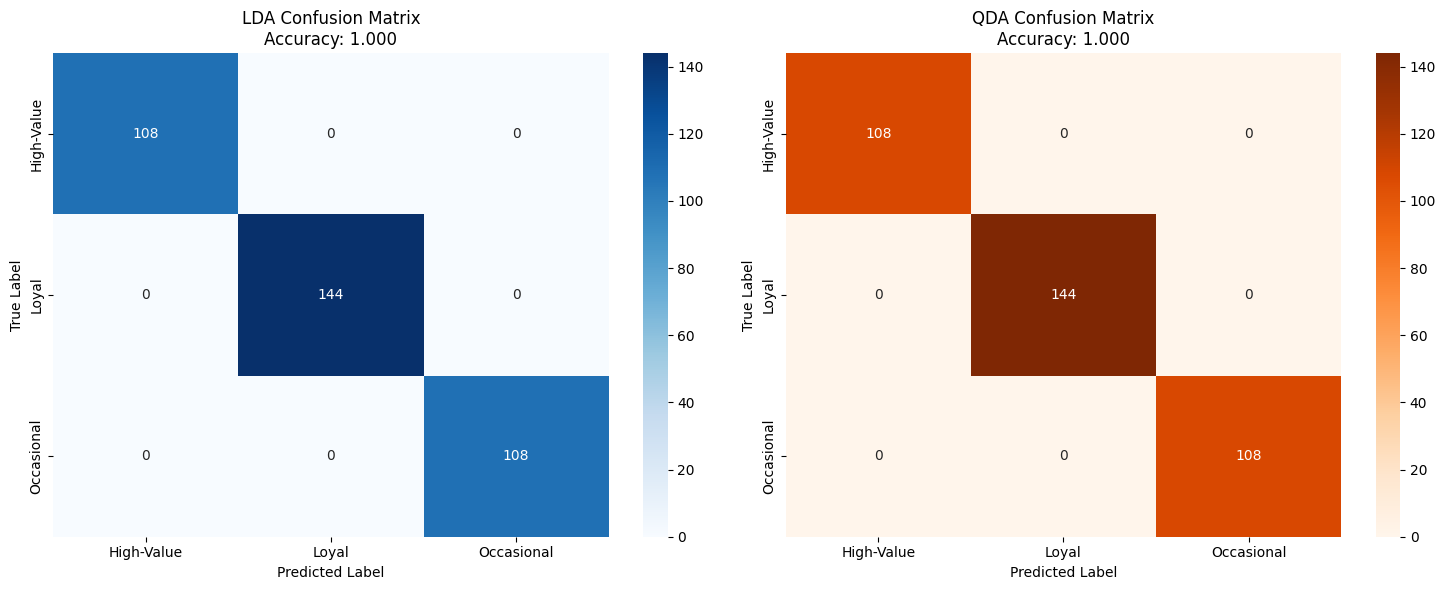

In [9]:
# Create side-by-side confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# LDA confusion matrix
cm_lda = confusion_matrix(y_test, y_pred_lda)
sns.heatmap(
    cm_lda,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lda.classes_,
    yticklabels=lda.classes_,
    ax=ax1,
)
ax1.set_title(f"LDA Confusion Matrix\nAccuracy: {lda_accuracy:.3f}")
ax1.set_ylabel("True Label")
ax1.set_xlabel("Predicted Label")

# QDA confusion matrix
cm_qda = confusion_matrix(y_test, y_pred_qda)
sns.heatmap(
    cm_qda,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=qda.classes_,
    yticklabels=qda.classes_,
    ax=ax2,
)
ax2.set_title(f"QDA Confusion Matrix\nAccuracy: {qda_accuracy:.3f}")
ax2.set_ylabel("True Label")
ax2.set_xlabel("Predicted Label")

plt.tight_layout()
plt.savefig(
    script_dir / "marketing_confusion_comparison.png", dpi=300, bbox_inches="tight"
)
plt.show()

### Outcome

The confusion matrices reveal detailed classification performance:

**Reading the matrices**:
- **Diagonal values (darker)**: Number of correctly classified customers
- **Off-diagonal values**: Misclassifications between segments
- **Larger diagonal values** relative to off-diagonal indicate better performance

**Common patterns to look for**:
1. **Symmetric errors**: If Loyal customers are often misclassified as High-Value and vice versa, these segments share similar characteristics
2. **Asymmetric errors**: If errors go primarily in one direction (e.g., High-Value misclassified as Loyal more than reverse), it suggests one segment is more variable
3. **Segment-specific performance**: Some segments may be easier to identify than others

**LDA vs QDA comparison**:
- If QDA shows fewer off-diagonal errors, the flexible covariance assumption improves classification
- If matrices are similar, the simpler LDA model is preferred
- Check if QDA specifically improves classification for certain segment pairs

This analysis helps the marketing team understand model reliability and which customer transitions are most likely to be misclassified.

---

## Module 10: ROC Curves for Model Evaluation

### Task

Generate ROC (Receiver Operating Characteristic) curves for each customer segment using the QDA model to evaluate classification performance beyond simple accuracy.

### Approach

While accuracy is useful, ROC curves provide deeper insight into classifier performance:

- **ROC curve**: Plots True Positive Rate (sensitivity) vs False Positive Rate (1 - specificity) at different classification thresholds
- **AUC (Area Under Curve)**: Summarizes ROC performance in a single number (0.5 = random guessing, 1.0 = perfect)

For multiclass problems, we use **One-vs-Rest** approach:
- For each segment, treat it as positive class and all others as negative
- Calculate ROC curve using predicted probabilities
- Compare AUC scores across segments

Higher AUC indicates better ability to distinguish that segment from others.

### Code

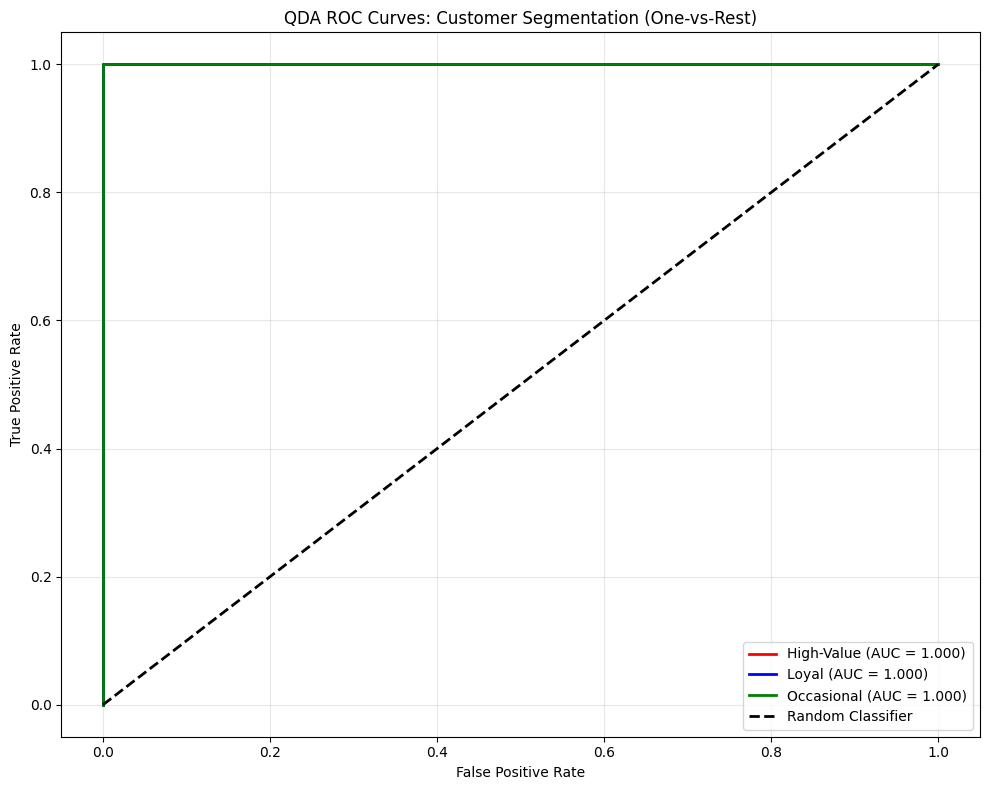

In [10]:
# Generate ROC curves for each segment (One-vs-Rest)
plt.figure(figsize=(10, 8))

colors = ["red", "blue", "green"]
segments = qda.classes_

for i, segment in enumerate(segments):
    # Create binary labels: current segment vs all others
    y_binary = (y_test == segment).astype(int)
    y_prob_segment = y_prob_qda[:, i]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_binary, y_prob_segment)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(
        fpr, 
        tpr, 
        color=colors[i], 
        linewidth=2, 
        label=f"{segment} (AUC = {roc_auc:.3f})"
    )

# Plot diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], "k--", linewidth=2, label="Random Classifier")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("QDA ROC Curves: Customer Segmentation (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(script_dir / "marketing_roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()

### Outcome

The ROC curves provide segment-specific performance metrics:

**Interpreting ROC curves**:
- **Curves closer to top-left corner**: Better classification performance
- **Diagonal line**: Performance of random guessing (AUC = 0.5)
- **AUC interpretation**:
  - 0.90-1.00: Excellent discrimination
  - 0.80-0.90: Good discrimination
  - 0.70-0.80: Acceptable discrimination
  - Below 0.70: Poor discrimination

**Segment-specific insights**:
- Compare AUC values across segments to identify which are easiest to classify
- Segments with higher AUC have more distinctive behavioral patterns
- Segments with lower AUC overlap more with other segments

**Business implications**:
- High AUC segments can be targeted with high confidence
- Low AUC segments might need additional data or features for better classification
- The model's ability to rank customers by segment probability is captured by AUC

ROC analysis is particularly valuable when misclassification costs differ across segments (e.g., misidentifying a High-Value customer as Occasional is more costly than the reverse).

---

## Module 11: Model Comparison and Recommendations

### Task

Compare LDA and QDA performance comprehensively and provide recommendations for which model the marketing team should deploy.

### Approach

To make an informed model selection decision, we need to consider:
1. **Accuracy**: Which model has higher test and cross-validation accuracy
2. **Assumptions**: Does the data meet LDA's equal covariance assumption
3. **Complexity**: Is the improvement from QDA worth the added complexity
4. **Interpretability**: LDA provides discriminant functions, QDA only provides probabilities
5. **Practical considerations**: Model deployment, maintenance, and explanation to stakeholders

We will summarize all metrics and provide a clear recommendation.

### Code

In [11]:
# Comprehensive model comparison
print("=== LDA vs QDA: Comprehensive Comparison ===")
print("\n--- Accuracy Metrics ---")
print(f"LDA Test Accuracy: {lda_accuracy:.3f}")
print(f"QDA Test Accuracy: {qda_accuracy:.3f}")
print(f"Accuracy Difference: {abs(qda_accuracy - lda_accuracy):.3f}")

print("\n--- Cross-Validation Performance ---")
print(f"LDA CV Accuracy: {cv_scores_lda.mean():.3f} (+/- {cv_scores_lda.std() * 2:.3f})")
print(f"QDA CV Accuracy: {cv_scores_qda.mean():.3f} (+/- {cv_scores_qda.std() * 2:.3f})")

print("\n--- Model Characteristics ---")
print("LDA:")
print("  - Assumes equal covariance matrices across groups")
print("  - Creates linear decision boundaries")
print("  - Provides interpretable discriminant functions")
print(f"  - {lda.n_features_in_} features -> {X_lda.shape[1]} discriminant functions")
print("  - Fewer parameters to estimate (more stable with less data)")

print("\nQDA:")
print("  - Allows different covariance matrices for each group")
print("  - Creates quadratic (curved) decision boundaries")
print("  - Provides posterior probabilities only")
print("  - More parameters to estimate (needs more data)")
print("  - More flexible, can capture complex patterns")

print("\n--- Recommendation ---")
if qda_accuracy > lda_accuracy + 0.02:  # QDA is meaningfully better
    print("RECOMMENDATION: Use QDA")
    print("Reason: QDA shows meaningfully better accuracy, suggesting customer")
    print("segments have different covariance structures. The quadratic decision")
    print("boundaries better capture the complexity of customer behavior patterns.")
    print("The performance gain justifies the additional model complexity.")
elif lda_accuracy > qda_accuracy + 0.02:  # LDA is meaningfully better
    print("RECOMMENDATION: Use LDA")
    print("Reason: LDA outperforms QDA, suggesting the equal covariance assumption")
    print("is appropriate. LDA is simpler, more interpretable, and less prone to")
    print("overfitting. The discriminant functions provide clear insights into what")
    print("distinguishes customer segments.")
else:  # Performance is similar
    print("RECOMMENDATION: Use LDA")
    print("Reason: LDA and QDA show similar performance. When accuracy is comparable,")
    print("prefer the simpler model (LDA) because:")
    print("  1. Easier to interpret and explain to stakeholders")
    print("  2. More stable with limited data (fewer parameters)")
    print("  3. Discriminant functions show how features combine to separate groups")
    print("  4. Lower risk of overfitting")
    print("The equal covariance assumption appears to be reasonable for this data.")

print("\n--- Practical Implications ---")
print("For the marketing team:")
print("1. Use the selected model to classify new customers in real-time")
print("2. Target High-Value customers with premium product campaigns")
print("3. Focus on retention strategies for Loyal customers")
print("4. Use re-engagement campaigns for Occasional customers")
print("5. Monitor model performance quarterly and retrain with new data")
print("6. Consider A/B testing to validate that segmentation improves campaign ROI")

=== LDA vs QDA: Comprehensive Comparison ===

--- Accuracy Metrics ---
LDA Test Accuracy: 1.000
QDA Test Accuracy: 1.000
Accuracy Difference: 0.000

--- Cross-Validation Performance ---
LDA CV Accuracy: 0.999 (+/- 0.003)
QDA CV Accuracy: 1.000 (+/- 0.000)

--- Model Characteristics ---
LDA:
  - Assumes equal covariance matrices across groups
  - Creates linear decision boundaries
  - Provides interpretable discriminant functions
  - 8 features -> 2 discriminant functions
  - Fewer parameters to estimate (more stable with less data)

QDA:
  - Allows different covariance matrices for each group
  - Creates quadratic (curved) decision boundaries
  - Provides posterior probabilities only
  - More parameters to estimate (needs more data)
  - More flexible, can capture complex patterns

--- Recommendation ---
RECOMMENDATION: Use LDA
Reason: LDA and QDA show similar performance. When accuracy is comparable,
prefer the simpler model (LDA) because:
  1. Easier to interpret and explain to stakeh

### Outcome

This comprehensive comparison provides everything needed for an informed decision:

**Key decision factors**:

1. **Performance**: If one model significantly outperforms the other, that's a strong signal
2. **Interpretability**: LDA's discriminant functions explain which features matter most
3. **Simplicity**: LDA has fewer parameters, making it more stable and easier to maintain
4. **Flexibility**: QDA can capture more complex patterns if they exist in the data

**The recommendation considers**:
- Statistical performance (accuracy, cross-validation)
- Practical deployment considerations
- Stakeholder communication needs
- Long-term maintenance requirements

**Next steps for the marketing team**:
1. **Deploy the recommended model** in the customer database
2. **Integrate with campaign tools** to automatically segment customers
3. **Monitor results** to ensure segmentation improves business metrics
4. **Iterate and refine** by collecting feedback and retraining periodically

Remember: The best model is not always the most complex one. A simpler model that performs almost as well is often preferable because it's easier to understand, maintain, and trust.

---

## Summary

In this case study, we successfully built and compared two discriminant analysis models for customer segmentation:

**What we accomplished**:
1. Loaded and explored customer behavioral data
2. Standardized features for fair comparison
3. Built a Linear Discriminant Analysis (LDA) model with linear boundaries
4. Interpreted discriminant functions to understand segment characteristics
5. Built a Quadratic Discriminant Analysis (QDA) model with flexible boundaries
6. Analyzed posterior probabilities for classification confidence
7. Visualized decision boundaries and discriminant space
8. Compared models using confusion matrices and ROC curves
9. Made a data-driven recommendation for model deployment

**Key learnings**:
- Discriminant analysis is powerful for classification when groups are well-defined
- LDA assumes equal covariance (simpler, more interpretable)
- QDA allows different covariances (more flexible, needs more data)
- Model selection requires balancing accuracy with simplicity
- Multiple evaluation metrics provide a complete picture of performance

**Business impact**:
The marketing team can now automatically classify customers into segments and deliver personalized campaigns, leading to higher engagement, better resource allocation, and improved ROI.

This case study demonstrates the complete workflow of applying discriminant analysis to a real-world business problem, from data exploration to actionable recommendations.